### Importation des librairies

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt


### Lecture des données et convertion des dates

In [2]:
df = pd.read_csv('../../data/collisions_routieres.csv')
mapbox_token = "pk.eyJ1IjoidG91amVyMDAiLCJhIjoiY2wwbWt6M3ptMTdhdTNibjU0OGFyMzc3ZiJ9.PYFp4yto8WHEODgZpWbDVQ"
px.set_mapbox_access_token(mapbox_token)
df["DT_ACCDN"] = pd.to_datetime(df["DT_ACCDN"])
df["year"] = df["DT_ACCDN"].dt.year
df["month"] = df["DT_ACCDN"].dt.month
df["day"] = df["DT_ACCDN"].dt.day
df["weekday"] = df["DT_ACCDN"].dt.weekday

### preparation des données utilisées pour la viz

In [3]:
def convert_gravite(x, split_mort_grave=False):
    # Takes GRAVITE as input
    if split_mort_grave:
        if x == 'Mortel':
            return 'MORTEL'
        elif x == 'Grave':
            return 'GRAVE'
        else:
            return 'LEGER_MATERIEL'
    else:
        
        if x in ['Mortel', 'Grave']:
            return 'GRAVE_MORTEL'
        else:
            return 'LEGER_MATERIEL'

    
def convert_type(x):
    #Takes nb_camionLourd_tractRoutier as input
    if x > 0:
        return 'CAMION'
    else:
        return 'SANS_CAMION'

In [4]:
# GRAVE_MORTEL OU LEGER_MATERIEL
df['GRAVITE_RENAME'] = df.loc[:, 'GRAVITE'].apply(lambda x : convert_gravite(x))
df['GRAVITE_SPLIT'] = df.loc[:, 'GRAVITE'].apply(lambda x : convert_gravite(x, split_mort_grave=True))

In [5]:
# CAMION OU SANS_CAMION
df['TYPE_VEHICULE'] = df.loc[:, 'nb_camionLourd_tractRoutier'].apply(lambda x: convert_type(x))

# MOKCUP

## Viz #1 : Est-ce que les accidents semblent diminuer à Montréal depuis l'annonce de Vision Zéro

#### Version nombre en fonction du temps

In [6]:
df1_count = df.groupby('DT_ACCDN').size()
df1_count.name = 'count'
df1_count = df1_count.rolling(7, min_periods=1).mean()

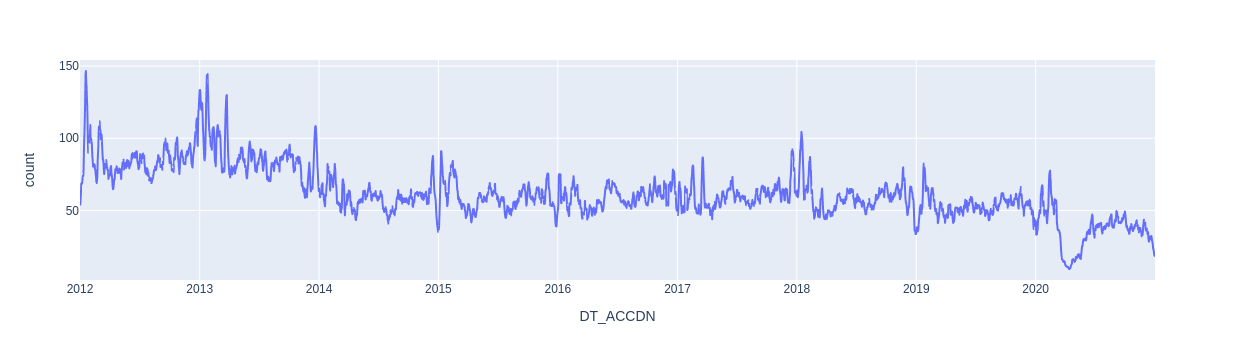

In [7]:
px.line(df1_count.reset_index(), x='DT_ACCDN', y='count')

### EXPORT  

In [8]:
df1_count.reset_index().rename(columns={'DT_ACCDN':'Date', 'count':'Nombres'}).to_csv('rolling7_viz1_all_vehicule_date.csv', index=False)

## Viz #2 : Est-ce que les accidents semblent diminuer à Montréal depuis l'annonce de Vision Zéro pour tous les types de véhicule

In [9]:
df2_count = df.groupby(['TYPE_VEHICULE','DT_ACCDN']).size()
df2_count.name = 'count'
df2_count = df2_count.rolling(7, min_periods=1).mean()

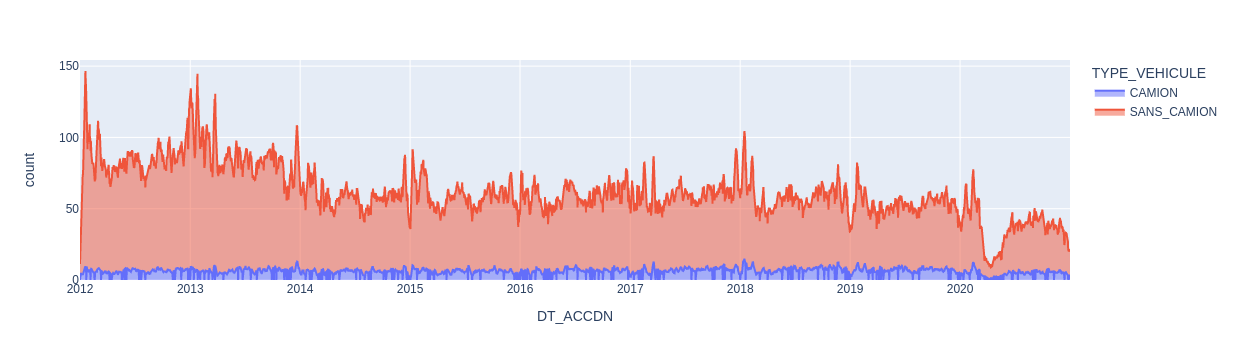

In [10]:
px.area(df2_count.reset_index(), x='DT_ACCDN', y='count', color='TYPE_VEHICULE', )

### EXPORT

In [11]:
df2_count.reset_index().rename(columns={'TYPE_VEHICULE':'Types', 'DT_ACCDN':'Date', 'count':'Nombres'}).to_csv('rolling7_viz2_acc_by_type_date.csv', index=False)

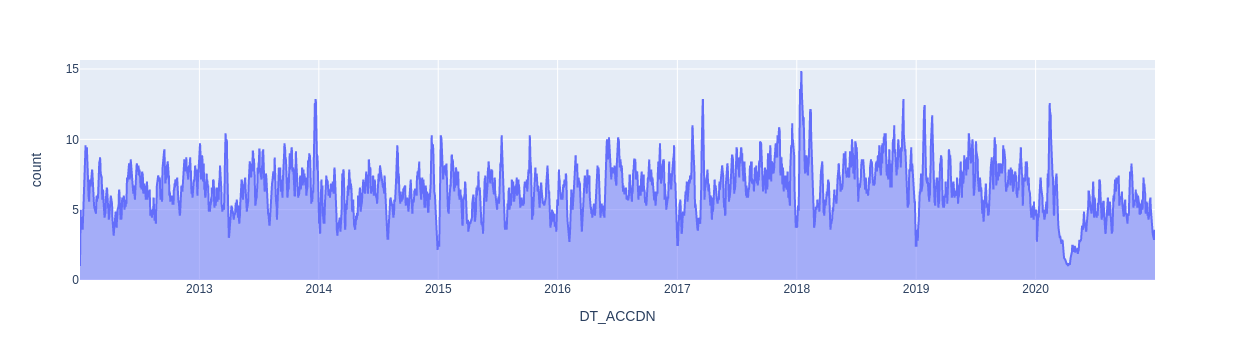

In [12]:
px.area(df2_count.loc['CAMION'].reset_index(), x='DT_ACCDN', y='count' )

## export date-camion_count

In [13]:
df2_count.loc['CAMION'].reset_index().rename(columns={'DT_ACCDN':'Date', 'count':'Nombres'}).to_csv('rolling7_viz3_acc_camion_date.csv', index=False)

## VIZ 3 : Quel est le ratio d'accident GM avec camion par rapport à lorsque les camions sont impliqués?

In [16]:
df3 = df.groupby(['TYPE_VEHICULE', 'GRAVITE_SPLIT']).size()
df3.name = 'count'
df3 = df3.reset_index()
df3['pourcentage'] = df3.apply(lambda row : row.loc['count'] *100 / df3[df3['TYPE_VEHICULE'] == row.loc['TYPE_VEHICULE']]['count'].sum(),
                         axis=1)

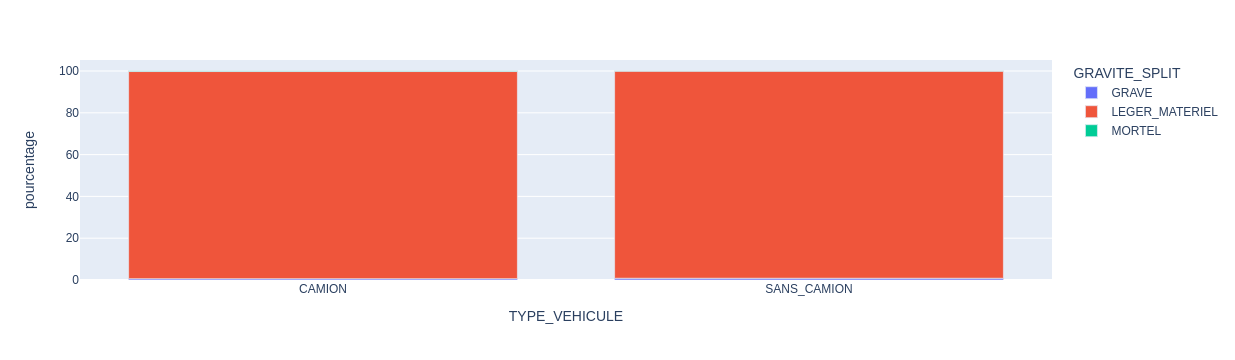

In [17]:
px.bar(df3, x='TYPE_VEHICULE', y='pourcentage', color='GRAVITE_SPLIT')

## VIZ 3 : CONTEXTE DES ACCIDENTS (

In [92]:
# Garder seulement les 20k accidents de camion et comprendre mieux les 174 qui sont graves ou mortel
# pour CD_ENVRN_ACCDN, CD_CATEG_ROUTE, VITESSE_AUTOR

In [18]:
def viz_context(data_df, var):
    col = ['TYPE_VEHICULE', 'GRAVITE_RENAME']
    col.append(var)
    df4 = data_df.groupby(col).size().loc['CAMION']
    df4.name = 'nombre'
    df4 = df4.reset_index()
    df4['pourcentage'] = df4.apply(lambda row : row.loc['nombre']/ df4[df4['GRAVITE_RENAME'] == row['GRAVITE_RENAME']]['nombre'].sum(),
                                   axis=1)
    fig = px.bar(df4,
        x=var,
        y='pourcentage',
        color='GRAVITE_RENAME',
        barmode='group')
    return fig


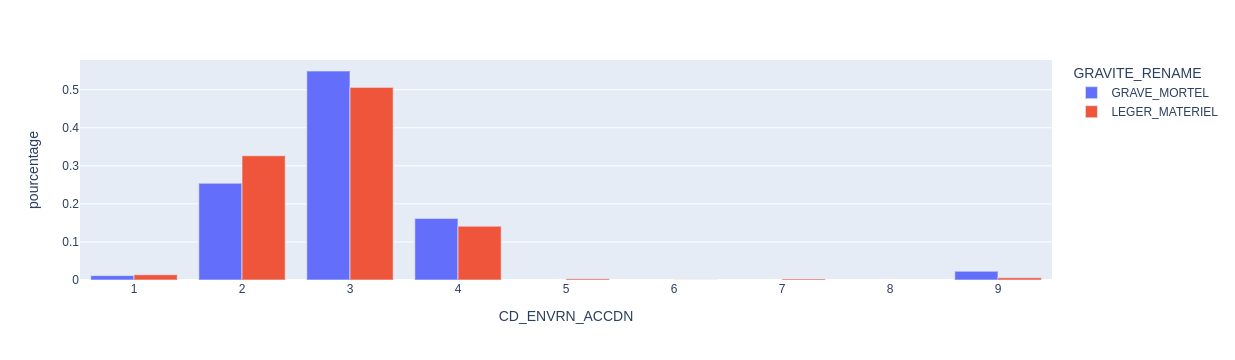

In [19]:
viz_context(df, 'CD_ENVRN_ACCDN')

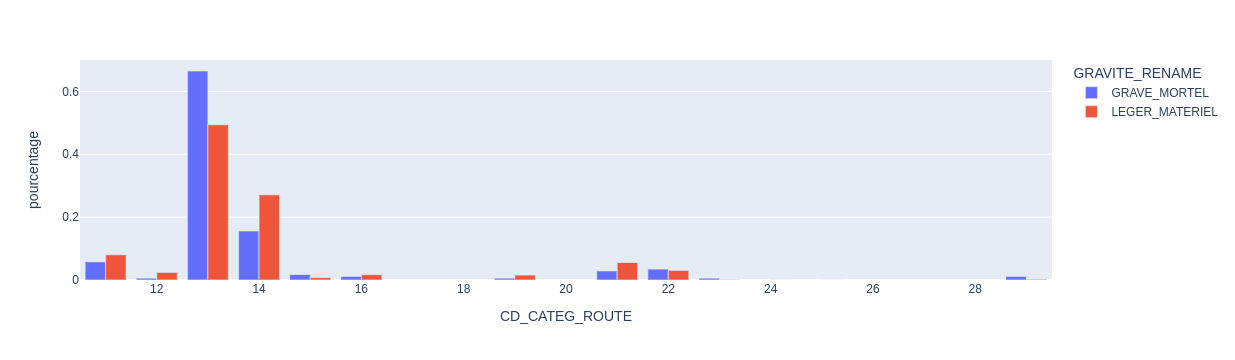

In [20]:
viz_context(df, 'CD_CATEG_ROUTE')

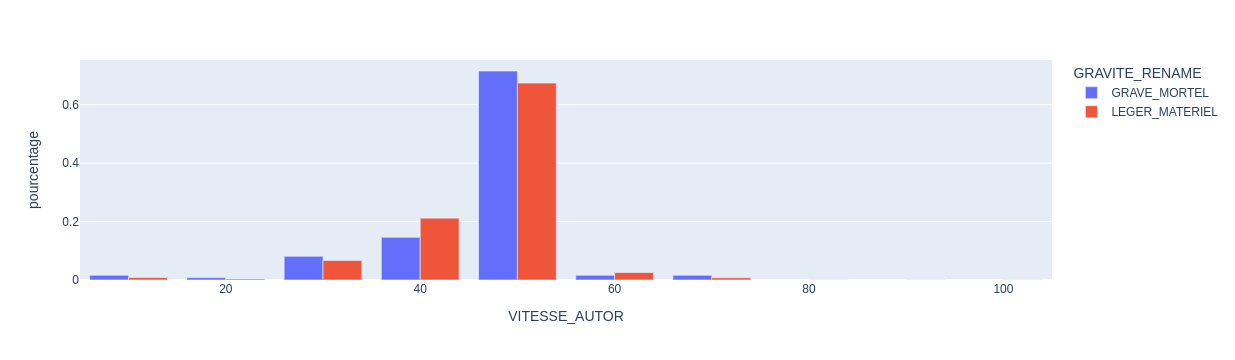

In [22]:
viz_context(df, 'VITESSE_AUTOR')

### TEST PARRALLE LEGISLATIF

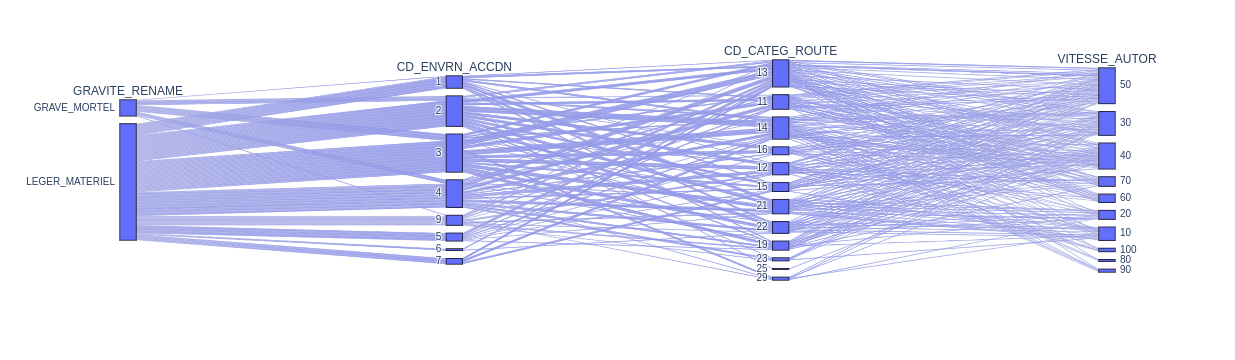

In [28]:
col5 = ['TYPE_VEHICULE', 'GRAVITE_RENAME', 'CD_ENVRN_ACCDN', 'CD_CATEG_ROUTE', 'VITESSE_AUTOR']
df5 = df.groupby(col5).size()
df5.name = 'count'
df5 = df5.loc['CAMION']
px.parallel_categories(df5.reset_index())

### EXPORT

#### Rename before export

In [32]:
df5_export = df5.reset_index().rename(columns={"GRAVITE_RENAME":"Gravite",
                                  "CD_ENVRN_ACCDN": "Environnement",
                                  "CD_CATEG_ROUTE" : "Route",
                                  "VITESSE_AUTOR" : "Vitesse"})
df5_export['Environnement'] = df5_export.loc[:,'Environnement'].replace({1.0:'Scolaire',
                                                                        2.0: 'Residentiel',
                                                                        3.0: 'Commercial',
                                                                        4.0: 'Industriel',
                                                                        5.0: 'Rural',
                                                                        6.0: 'Forestier',
                                                                        7.0: 'Recreatif',
                                                                        9.0: 'Autre',
                                                                        0.0: 'ND})

0      hello
1        2.0
2        2.0
3        2.0
4        2.0
       ...  
236      9.0
237      9.0
238      9.0
239      9.0
240      9.0
Name: Environnement, Length: 241, dtype: object

In [144]:
df5

GRAVITE_RENAME  CD_ENVRN_ACCDN  CD_CATEG_ROUTE  VITESSE_AUTOR  count
0      GRAVE_MORTEL             1.0            13.0           50.0      1
1      GRAVE_MORTEL             2.0            11.0           50.0      1
2      GRAVE_MORTEL             2.0            13.0           30.0      1
3      GRAVE_MORTEL             2.0            13.0           40.0      2
4      GRAVE_MORTEL             2.0            13.0           50.0     11
..              ...             ...             ...            ...    ...
236  LEGER_MATERIEL             9.0            21.0           10.0      2
237  LEGER_MATERIEL             9.0            21.0           20.0      1
238  LEGER_MATERIEL             9.0            22.0           20.0      1
239  LEGER_MATERIEL             9.0            23.0           50.0      1
240  LEGER_MATERIEL             9.0            29.0           20.0      1

[241 rows x 5 columns]

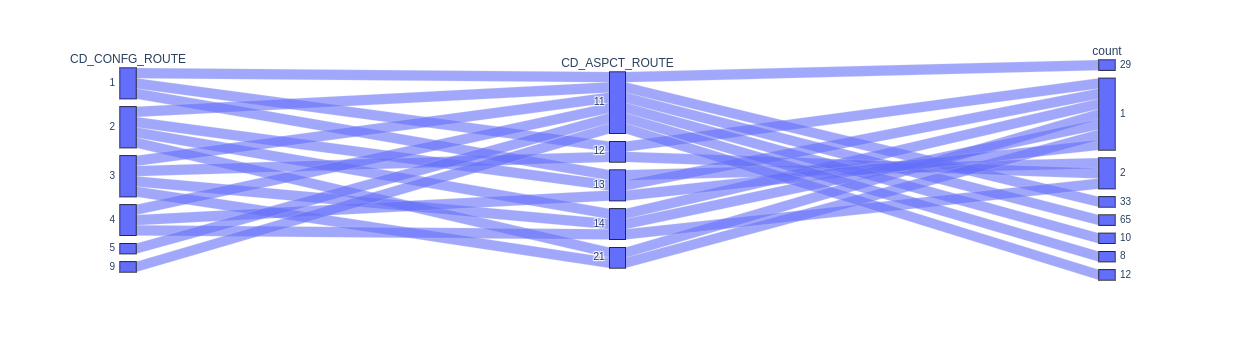

In [158]:
col6 = ['TYPE_VEHICULE', 'GRAVITE_RENAME', 'CD_CONFG_ROUTE', 'CD_ASPCT_ROUTE']
df6 = df.groupby(col6).size()
df6.name = 'count'
df6 = df6.loc['CAMION'].loc['GRAVE_MORTEL'].reset_index()
px.parallel_categories(df6.iloc[:, 0:3])

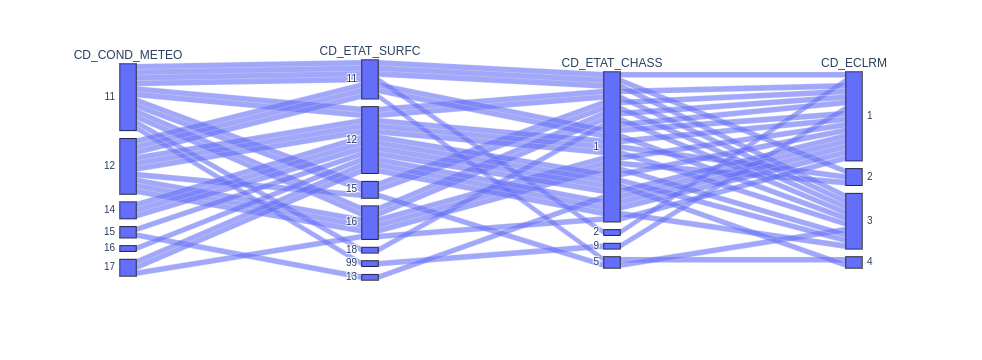

In [157]:
col7 = ['TYPE_VEHICULE', 'GRAVITE_RENAME', 'CD_COND_METEO', 'CD_ETAT_SURFC', 'CD_ETAT_CHASS', 'CD_ECLRM']
df7 = df.groupby(col7).size()
df7.name = 'count'
df7 = df7.loc['CAMION'].loc['GRAVE_MORTEL'].reset_index()
px.parallel_categories(df7.iloc[:,:-1])